<a href="https://colab.research.google.com/github/Sankarsh-Sunku/Implementation-Of-DL-in-Pytorch/blob/main/Data/Save_the_Best_Model_Based_on_DevSet_Acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [9]:
theBest = [0,0]

for i in range(10):

  # "train the model"
  accuracy = np.random.rand()

  # see if this is better than any previous runs
  if accuracy>theBest[0]:
    theBest = [accuracy,i]


print(f'Highest "accuracy" was {100*theBest[0]:.2f}% in run {theBest[1]+1}.')

Highest "accuracy" was 94.23% in run 4.


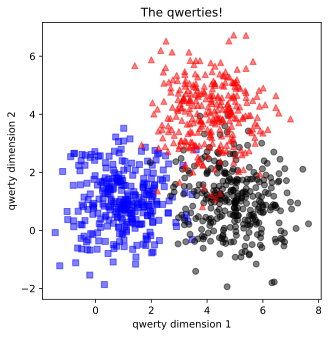

In [10]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 4 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [11]:
# specify sizes of the partitions
# order is train,devset,test
partitions = [3*nPerClust-400,200,200]

# split the data
train_data,devtest_data, train_labels,devtest_labels = train_test_split(data, labels, train_size=partitions[0])

# now split the devtest data
dev_data,test_data, dev_labels,test_labels = train_test_split(devtest_data, devtest_labels, train_size=partitions[1])


# print out the sizes
print('   Total data size: ' + str(data.shape) + '\n')
print('Training data size: ' + str(train_data.shape))
print('  Devset data size: ' + str(dev_data.shape))
print('    Test data size: ' + str(test_data.shape))

   Total data size: torch.Size([900, 2])

Training data size: torch.Size([500, 2])
  Devset data size: torch.Size([200, 2])
    Test data size: torch.Size([200, 2])


In [12]:
# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
dev_data   = TensorDataset(dev_data,dev_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 30
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(dev_data,batch_size=dev_data.tensors[0].shape[0])
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [13]:
# create a class for the model
def createTheQwertyNet():

  class qwertyNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,8)

      ### hidden layer
      self.fc1 = nn.Linear(8,8)

      ### output layer
      self.output = nn.Linear(8,3)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      return self.output(x)

  # create the model instance
  net = qwertyNet()

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer


In [14]:
def function2trainTheModel():

  # New! initialize a dictionary for the best model
  theBestModel = {'Accuracy':0, 'net':None}


  # number of epochs
  numepochs = 100

  # create a new model
  net,lossfun,optimizer = createTheQwertyNet()

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  devAcc   = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval()
    X,y = next(iter(dev_loader)) # extract X,y from devset dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    # compare the following really long line of code to the training accuracy lines
    devAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )


    # New! Store this model if it's the best so far
    if devAcc[-1]>theBestModel['Accuracy']:

      # new best accuracy
      theBestModel['Accuracy'] = devAcc[-1].item()

      # model's internal state
      theBestModel['net'] = copy.deepcopy( net.state_dict() )

  # end epochs

  # function output
  return trainAcc,devAcc,losses,theBestModel


In [15]:
trainAcc,devAcc,losses,theBestModel = function2trainTheModel()

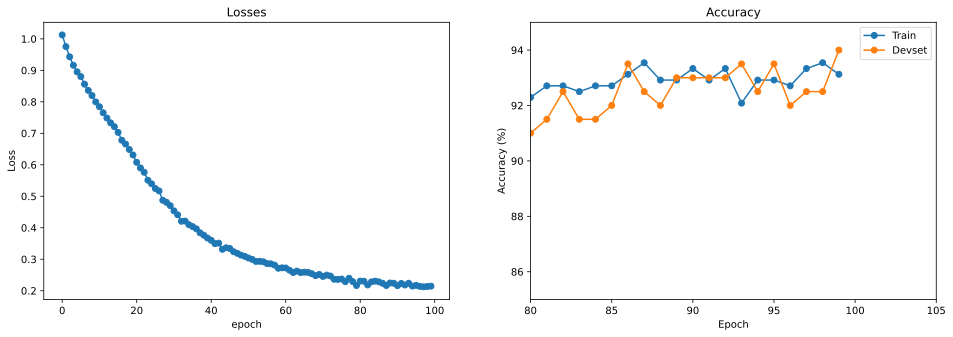

In [16]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses.detach(),'o-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(trainAcc,'o-',label='Train')
ax[1].plot(devAcc,'o-',label='Devset')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].set_ylim([85,95])
ax[1].set_xlim([80,105])
ax[1].legend()
plt.show()

In [17]:
theBestModel

{'Accuracy': 94.0,
 'net': OrderedDict([('input.weight',
               tensor([[ 0.6302, -0.1885],
                       [-0.4177,  0.2918],
                       [ 0.1476, -0.1323],
                       [ 0.5707, -0.4994],
                       [ 0.3358,  0.3437],
                       [ 0.9639, -0.1008],
                       [-0.6311, -0.1976],
                       [ 0.1652,  0.7714]])),
              ('input.bias',
               tensor([-0.7810,  0.3554,  0.5534,  0.2308, -0.6384, -0.6003,  0.2657, -0.8753])),
              ('fc1.weight',
               tensor([[-1.0196e-01, -3.4489e-01,  3.2646e-01,  1.6318e-01, -3.1645e-01,
                        -1.9779e-01,  2.2795e-01,  2.2600e-01],
                       [-2.6018e-01,  9.1705e-02,  4.9030e-01,  3.8538e-01, -5.3561e-02,
                        -9.8057e-03, -5.2954e-02,  5.9112e-02],
                       [ 5.4687e-01, -3.0909e-01, -1.9643e-01, -7.0034e-03,  3.1231e-01,
                         7.4270e-01,  1.0623e

In [18]:
# extract X,y from test dataloader
X,y = next(iter(test_loader))

# yHat = theBestModel['net'](X)

In [19]:
# recreate the best-performing model
bestnet = createTheQwertyNet()[0]
bestnet.load_state_dict(theBestModel['net'])


<All keys matched successfully>

In [20]:
# and run the data through TEST
X,y = next(iter(test_loader))
yHat = bestnet(X)

bestAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
bestAcc

tensor(93.5000)

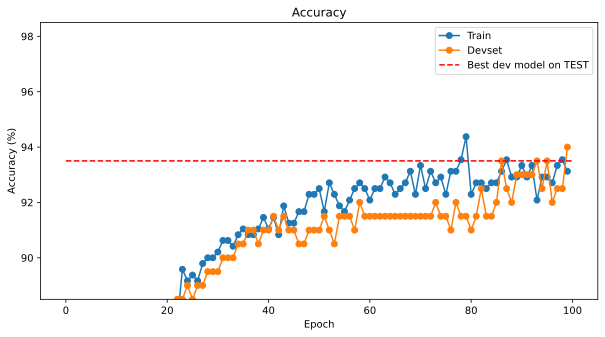

In [21]:
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'o-',label='Train')
plt.plot(devAcc,'o-',label='Devset')
plt.plot([0,len(devAcc)],[bestAcc,bestAcc],'r--',label='Best dev model on TEST')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.ylim([bestAcc-5,bestAcc+5])
plt.legend()
plt.show()